In [81]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
from matplotlib.patches import Rectangle
from torchaudio.utils import download_asset

2.2.0+cu118
2.2.0+cu118


In [82]:
image_width = 157
audio_len = 32000 * 5
hop_length = audio_len // (image_width - 1)

In [83]:
waveform, sample_rate = torchaudio.load(
    "../../data/birdclef-2023/train_audio/abythr1/XC122413.ogg"
)
transform = torchaudio.transforms.MelSpectrogram(
    sample_rate,
    n_mels=128,
    n_fft=2048,
    hop_length=hop_length,
    f_min=40,
    f_max=15000,
)
amlif_db = torchaudio.transforms.AmplitudeToDB()
mel_spectrogram = transform(waveform[:, 0 : 32000 * 5])
mel_spectrogram = amlif_db(mel_spectrogram).numpy()
print(mel_spectrogram.shape)
# pseudo_rgb_spectrogram = np.repeat(mel_spectrogram[..., np.newaxis], 3, axis=-1)

(1, 128, 157)


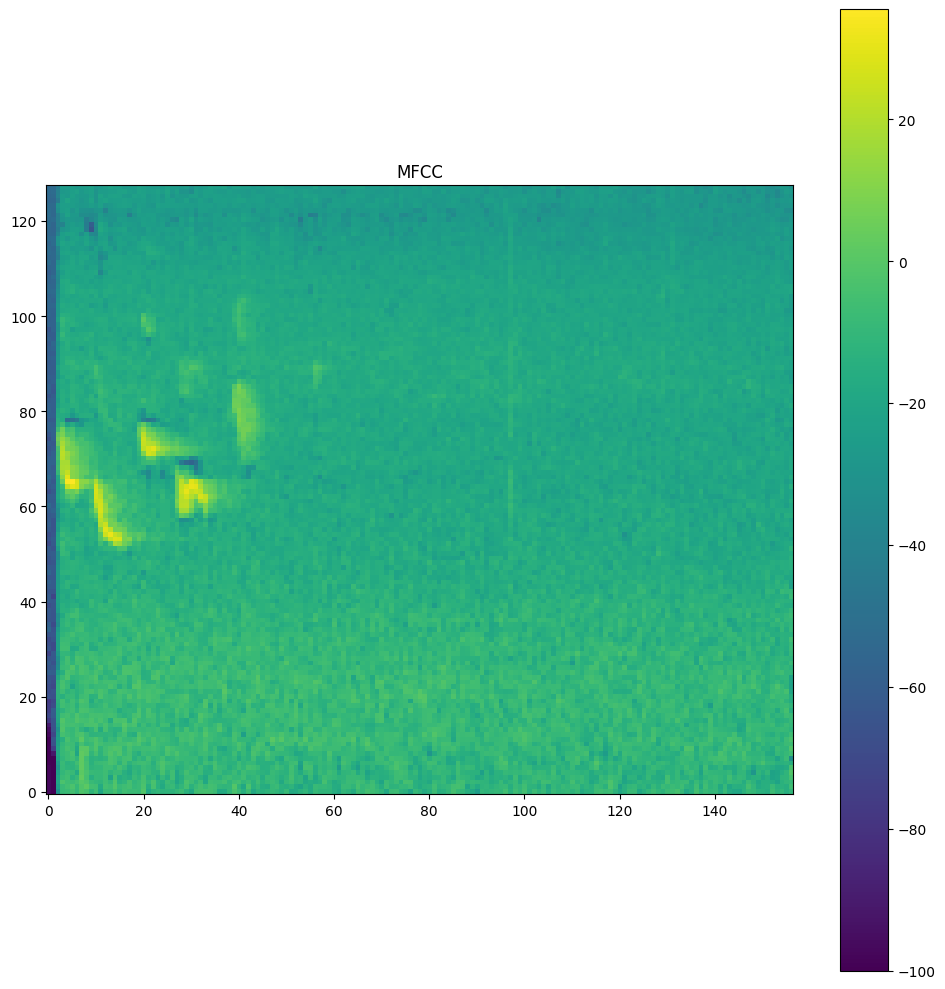

In [84]:
plt.figure(figsize=(10, 10))
plt.imshow(mel_spectrogram[0], cmap="viridis", origin="lower")
plt.colorbar()
plt.title("MFCC")
plt.tight_layout()
plt.show()

In [34]:
Audio(waveform[:, 0 : 32000 * 5], rate=sample_rate)

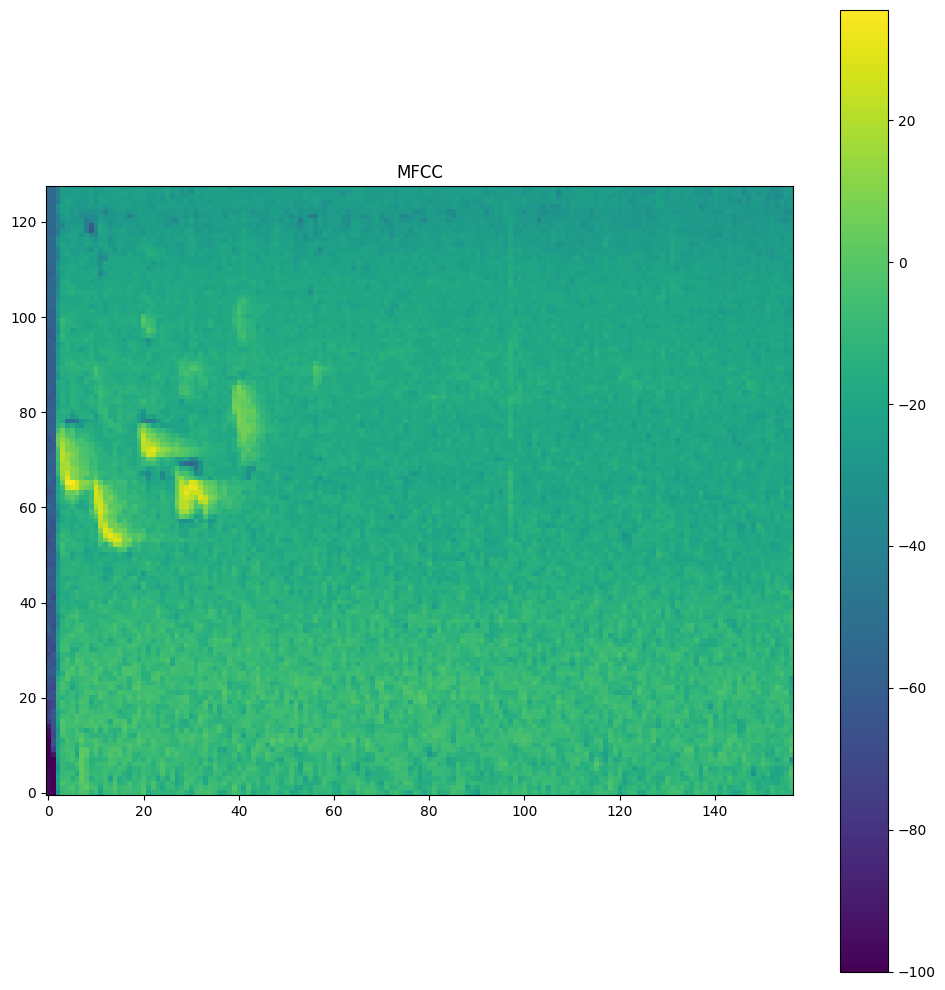

In [35]:
plt.figure(figsize=(10, 10))
plt.imshow(mel_spectrogram[0], cmap="viridis", origin="lower")
plt.colorbar()
plt.title("MFCC")
plt.tight_layout()
plt.show()

In [16]:
def generate_chroma_feature(
    waveform, sr=22050, n_fft=2048, hop_length=512, n_chroma=128, epsilon=1e-6
):

    # Compute STFT
    stft = torch.stft(waveform, n_fft=n_fft, hop_length=hop_length, return_complex=True)
    magnitude = stft.abs() + epsilon

    # Create a chroma filter bank
    chroma_filter = librosa.filters.chroma(sr=sr, n_fft=n_fft, n_chroma=n_chroma)
    chroma_filter = torch.tensor(chroma_filter, dtype=torch.float32)

    # Apply the chroma filter bank
    chroma = torch.matmul(chroma_filter, magnitude.squeeze(0))

    # Normalize the chroma features
    chroma = chroma / torch.max(chroma) + epsilon

    return chroma

In [17]:
chroma = generate_chroma_feature(waveform, sample_rate).unsqueeze(0).unsqueeze(0)
print(chroma.shape)

torch.Size([1, 1, 128, 1687])


In [18]:
interpolated_chroma = torch.nn.functional.interpolate(
    chroma, size=mel_spectrogram.shape[1:], mode="bilinear"
).squeeze(0)

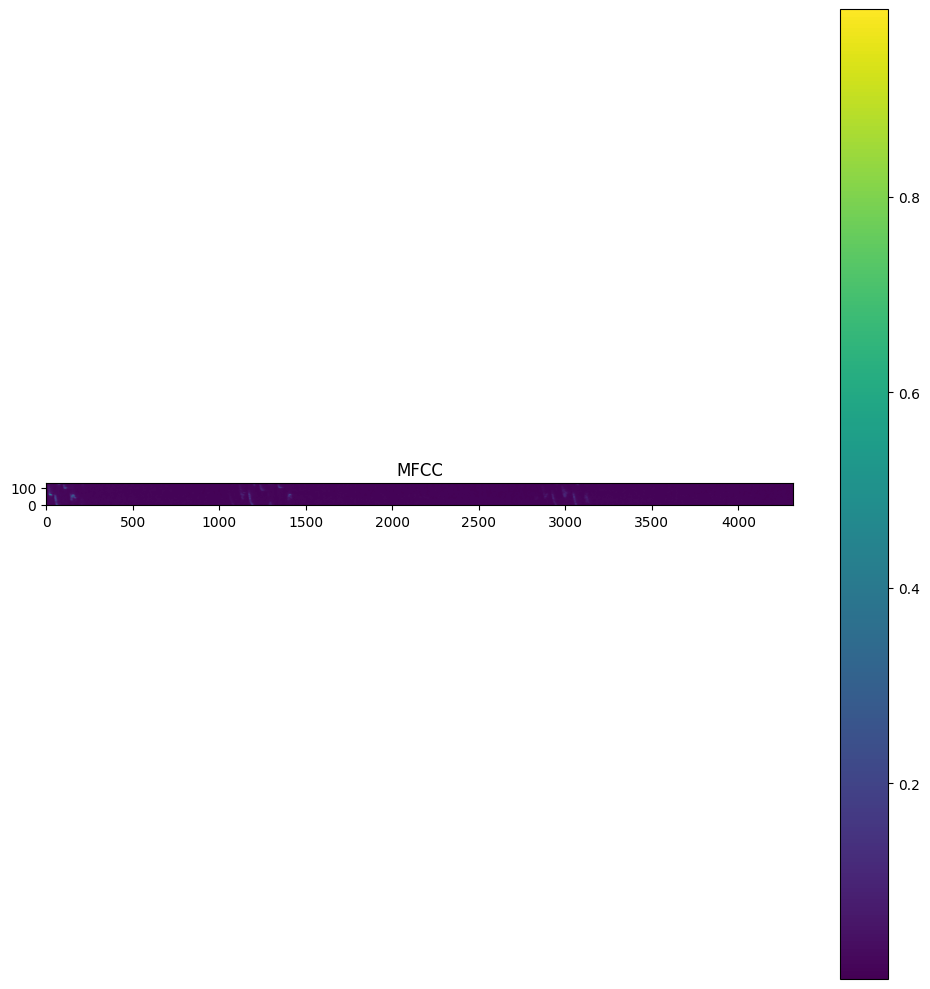

In [19]:
plt.figure(figsize=(10, 10))
plt.imshow(interpolated_chroma[0], cmap="viridis", origin="lower")
plt.colorbar()
plt.title("MFCC")
plt.tight_layout()
plt.show()

In [20]:
# apply MFCC
transform = torchaudio.transforms.MFCC(
    sample_rate=sample_rate, n_mfcc=128, melkwargs={"n_fft": 2028, "hop_length": 512}
)
mfcc = transform(waveform)
mfcc = (mfcc - torch.min(mfcc)) / (torch.max(mfcc) - torch.min(mfcc))
# mfcc = mfcc.squeeze(0).numpy()
print(mfcc.shape)

torch.Size([1, 128, 1687])


In [21]:
mfcc2 = torch.nn.functional.interpolate(
    mfcc.unsqueeze(0), size=mel_spectrogram.shape[1:], mode="bilinear"
).squeeze(0)

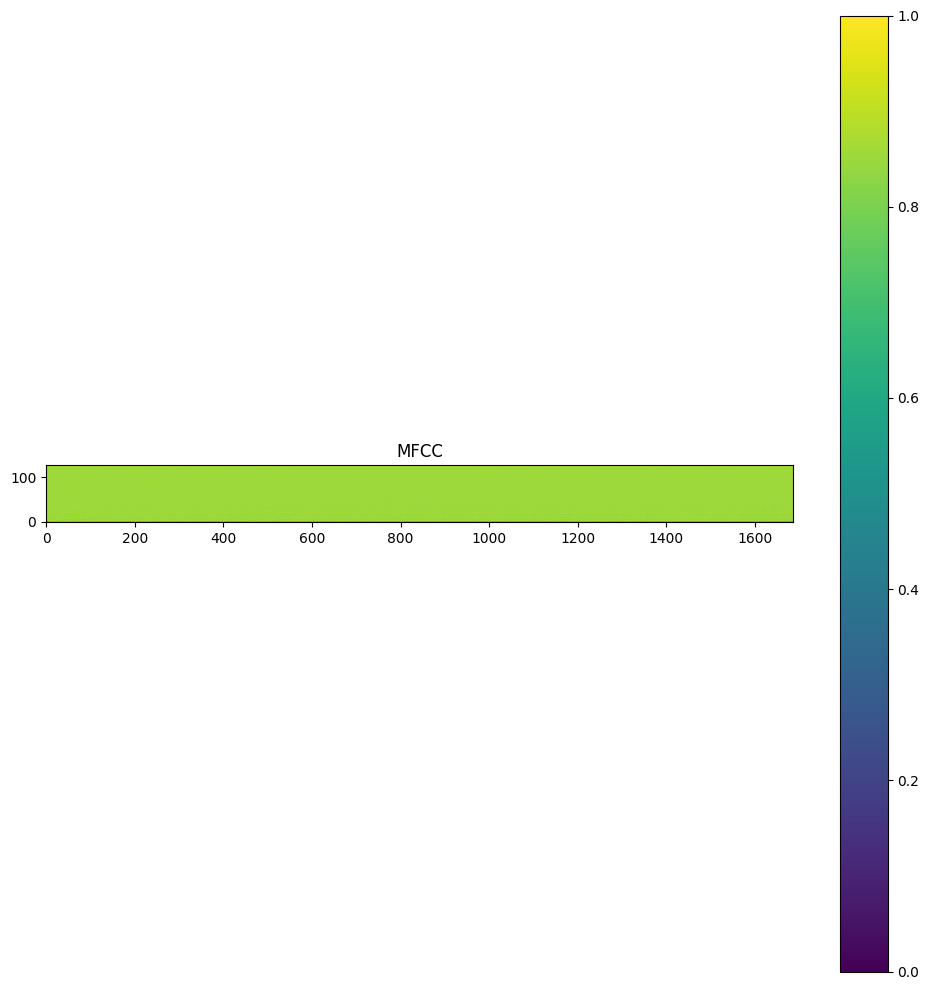

In [22]:
# plot the MFCC
plt.figure(figsize=(10, 10))
# fix for Invalid shape (1, 128, 205) for image data
# plt.imshow(mfcc[0], cmap="viridis", origin="lower")

plt.imshow(mfcc[0], cmap="viridis", origin="lower")
plt.colorbar()
plt.title("MFCC")
plt.tight_layout()
plt.show()

In [23]:
waveform_mono = torch.mean(waveform, dim=0, keepdim=True)

In [4]:
Audio(waveform_mono[0].numpy(), rate=sample_rate)

In [14]:
spectrogram_transforms = []

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    32000,
    n_mels=128,
    n_fft=2028,
    hop_length=512,
    f_max=16000,
    f_min=20,
)
amplitude_to_db = torchaudio.transforms.AmplitudeToDB(top_db=80)

spectrogram_transforms.append(mel_spectrogram)
spectrogram_transforms.append(amplitude_to_db)

In [15]:
mel_spectrogram

MelSpectrogram(
  (spectrogram): Spectrogram()
  (mel_scale): MelScale()
)

In [9]:
waveform

tensor([[-2.6502e-05, -3.8943e-06,  1.4102e-06,  ..., -7.6963e-06,
          8.7922e-06,  2.1860e-06]])

In [16]:
mel_spectrogram(torch.tensor(waveform))

/tmp/ipykernel_34773/1367998726.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mel_spectrogram(torch.tensor(waveform))


tensor([[[3.1310e-06, 1.0875e-05, 1.6202e+01,  ..., 9.0579e+01,
          3.0737e+01, 3.9262e+00],
         [4.6850e-06, 1.0458e-05, 1.6317e+01,  ..., 1.2661e+02,
          3.9244e+01, 4.4172e+00],
         [9.0956e-06, 2.6560e-05, 1.4520e+01,  ..., 3.2989e+02,
          7.7588e+01, 3.9310e+00],
         ...,
         [5.3836e-06, 1.4553e-05, 7.2749e-03,  ..., 6.8558e-02,
          5.6374e-02, 6.5249e-03],
         [1.4454e-06, 2.6922e-06, 1.5788e-03,  ..., 4.1728e-02,
          1.9261e-02, 2.2144e-03],
         [2.7676e-07, 7.6364e-08, 1.5890e-05,  ..., 5.7326e-03,
          1.8200e-03, 9.4488e-05]]])

In [18]:
a = amplitude_to_db(mel_spectrogram(waveform))

In [19]:
a.shape

torch.Size([1, 128, 205])

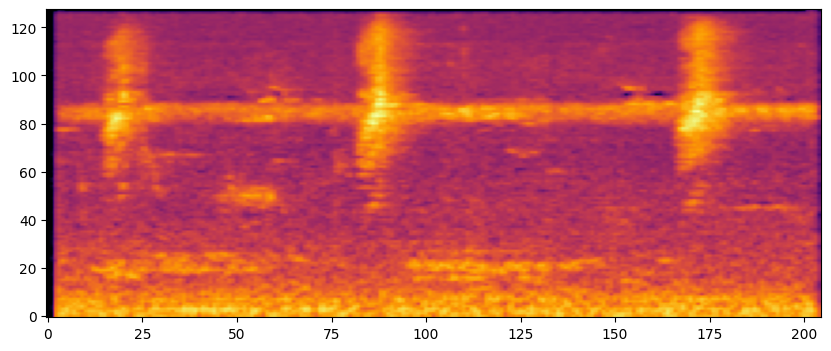

In [17]:
# draw the spectrogram with the transforms
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.imshow(
    amplitude_to_db(mel_spectrogram(waveform)).squeeze().numpy(),
    aspect="auto",
    origin="lower",
    cmap="inferno",
)
plt.show()

In [14]:
waveform[:, int(waveform.shape[1] * 0.1) : waveform.shape[1]]

tensor([[-3.3105e-02,  4.6828e-02,  1.0316e-01,  ..., -7.6963e-06,
          8.7922e-06,  2.1860e-06]])

In [12]:
Audio(waveform[0], rate=sample_rate)

In [27]:
torch.randint(0, 3, (1,)).item()

tensor([1])

In [15]:
duration = len(waveform[0]) / sample_rate

while duration < 5:
    waveform = torch.cat(
        (waveform, waveform[:, int(waveform.shape[1] * 0.1) : waveform.shape[1]]), dim=1
    )
    duration = len(waveform[0]) / sample_rate

In [16]:
Audio(waveform[0], rate=sample_rate)

In [31]:
waveform.shape

torch.Size([1, 92096])

In [23]:
# Define transform
spectrogram = T.Spectrogram(n_fft=512)

# Perform transform
spec = spectrogram(waveform)


melspec = T.AmplitudeToDB()(spec)

In [25]:
plot_spectrogram(melspec, title="spectrogram")

NameError: name 'plot_spectrogram' is not defined

In [49]:
# if len(pseudo_rgb_spectrogram.shape) > 1:  # Handle multi-channel audio if needed
#     pseudo_rgb_spectrogram = librosa.power_to_db(pseudo_rgb_spectrogram, ref=np.max)

In [16]:
pseudo_rgb_spectrogram = pseudo_rgb_spectrogram.squeeze()

In [27]:
pseudo_rgb_spectrogram.shape

(128, 461, 3)

In [28]:
pseudo_rgb_spectrogram = librosa.power_to_db(melspec, ref=np.max)

In [29]:
pseudo_rgb_spectrogram

array([[[-80., -80., -80., ..., -80., -80., -80.],
        [-80., -80., -80., ..., -80., -80., -80.],
        [-80., -80., -80., ..., -80., -80., -80.],
        ...,
        [-80., -80., -80., ..., -80., -80., -80.],
        [-80., -80., -80., ..., -80., -80., -80.],
        [-80., -80., -80., ..., -80., -80., -80.]]], dtype=float32)

TypeError: Invalid shape (1, 257, 360) for image data

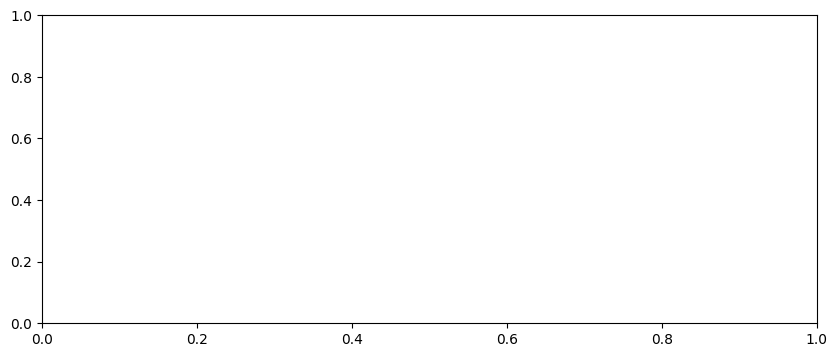

In [30]:
plt.figure(figsize=(10, 4))
plt.imshow(
    pseudo_rgb_spectrogram,
    origin="lower",
    aspect="auto",
    interpolation="nearest",
)  # Use a suitable colormap
# plt.colorbar(label="Amplitude (dB)")
# plt.xlabel("Time")
# plt.ylabel("Mel Frequency")
# plt.title("Mel Spectrogram")
# plt.tight_layout()
plt.show()

In [7]:
n_fft = 2028
hop_length = 512
n_mels = 128
waveform, sample_rate = torchaudio.load(
    "../../data/birdclef-2024/train_audio/bkrfla1/XC116440.ogg"
)


class DataProcessing:
    @staticmethod
    def record_to_frames(waveform, sample_rate, frame_size=5):
        p1d = (1, sample_rate * frame_size)
        out = torch.nn.functional.pad(waveform, p1d, "constant", 0)
        return out.unfold(0, sample_rate * frame_size, sample_rate * frame_size)

    @staticmethod
    def my_collate(batch):
        frames = []
        labels = []
        for data, label in batch:
            waveform, sample_rate, name = data
            l_frames = DataProcessing.record_to_frames(waveform, sample_rate)

            for index in range(l_frames.size()[0]):
                frame = l_frames[index]
                # audio_spectogram = spectogram(frame)
                # audio_spectogram = audio_spectogram.repeat(3, 1, 1)
                frames.append((frame, sample_rate, f"{name}_{index}"))
                labels.append(label)
        return [frames, labels]

    @staticmethod
    def melgram(audio, sample_rate, to_file):
        # librosa.power_to_db(specgram),
        # origin="lower",
        # aspect="auto",
        # interpolation="nearest",
        plt.figure(figsize=(4, 2))
        plt.axis("off")  # no axis
        plt.axes(
            [0.0, 0.0, 1.0, 1.0], frameon=False, xticks=[], yticks=[]
        )  # Remove the white edge
        melspectrogram = librosa.feature.melspectrogram(
            y=audio, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
        )
        plt.imshow(
            librosa.power_to_db(melspectrogram, ref=np.max),
            origin="lower",
            aspect="auto",
            interpolation="nearest",  # prevent blurring
        )
        # librosa.display.specshow(
        #     librosa.power_to_db(
        #         melspectrogram,
        #         ref=np.max,
        #     ),
        #     # origin="lower",
        #     # aspect="auto",
        #     # interpolation="nearest",
        # )
        plt.savefig(to_file, bbox_inches=None, pad_inches=0)
        plt.close()

In [8]:
DataProcessing.melgram(
    waveform[0].numpy(), sample_rate, f"{n_fft}_{hop_length}_{n_mels}.png"
)

In [24]:
def generate_chroma_feature(waveform, sr, n_fft, hop_length, n_chroma):

    # Compute STFT
    stft = torch.stft(
        waveform,
        n_fft=n_fft,
        hop_length=hop_length,
        return_complex=True,
        win_length=n_fft,
        window=torch.hann_window(n_fft),
    )
    magnitude = stft.abs()

    # Create a chroma filter bank
    chroma_filter = librosa.filters.chroma(sr=sr, n_fft=n_fft, n_chroma=n_chroma)
    chroma_filter = torch.tensor(chroma_filter, dtype=torch.float32)

    # Apply the chroma filter bank
    chroma = torch.matmul(chroma_filter, magnitude.squeeze(0))

    # Normalize the chroma features
    chroma = chroma / torch.max(chroma)

    return chroma


class MonoToThreeChannel(torch.nn.Module):

    def __init__(self, sr, n_mels, n_mfcc, hop_length, n_chroma, n_fft):
        super(MonoToThreeChannel, self).__init__()
        self.sr = sr
        self.n_mels = n_mels
        self.n_mfcc = n_mfcc
        self.n_chroma = n_chroma
        self.n_fft = n_fft
        self.hop_length = hop_length

        self.mel_spectrogram_transform = T.MelSpectrogram(
            sample_rate=self.sr,
            n_mels=self.n_mels,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
        )
        self.amplitude_db_transform = T.AmplitudeToDB()
        self.mfcc_transform = T.MFCC(sample_rate=self.sr, n_mfcc=self.n_mels)

    def forward(self, waveform):
        # Mel Spectrogram
        mel_spectrogram = self.mel_spectrogram_transform(waveform)
        mel_spectrogram_db = self.amplitude_db_transform(mel_spectrogram)

        # MFCC
        mfcc = self.mfcc_transform(waveform)

        # Chromagram from Mel Spectrogram
        chroma = generate_chroma_feature(
            waveform,
            sr=self.sr,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            n_chroma=self.n_chroma,
        ).unsqueeze(0)

        # Normalize features to the same scale
        mel_spectrogram_db = (mel_spectrogram_db - torch.min(mel_spectrogram_db)) / (
            torch.max(mel_spectrogram_db) - torch.min(mel_spectrogram_db)
        )
        mfcc = (mfcc - torch.min(mfcc)) / (torch.max(mfcc) - torch.min(mfcc))
        chroma = (chroma - torch.min(chroma)) / (torch.max(chroma) - torch.min(chroma))

        # Resize MFCC and Chroma to match Mel Spectrogram dimensions
        mfcc_resized = torch.nn.functional.interpolate(
            mfcc.unsqueeze(0), size=mel_spectrogram_db.shape[1:], mode="bilinear"
        ).squeeze(0)
        chroma_resized = torch.nn.functional.interpolate(
            chroma.unsqueeze(0), size=mel_spectrogram_db.shape[1:], mode="bilinear"
        ).squeeze(0)

        # Stack to create a 3-channel image
        return torch.stack(
            (mel_spectrogram_db, mfcc_resized, chroma_resized), dim=0
        ).squeeze(1)

In [25]:
mono_to = MonoToThreeChannel(sample_rate, 128, 128, 512, 128, 2028)
threeChanels = mono_to(waveform)

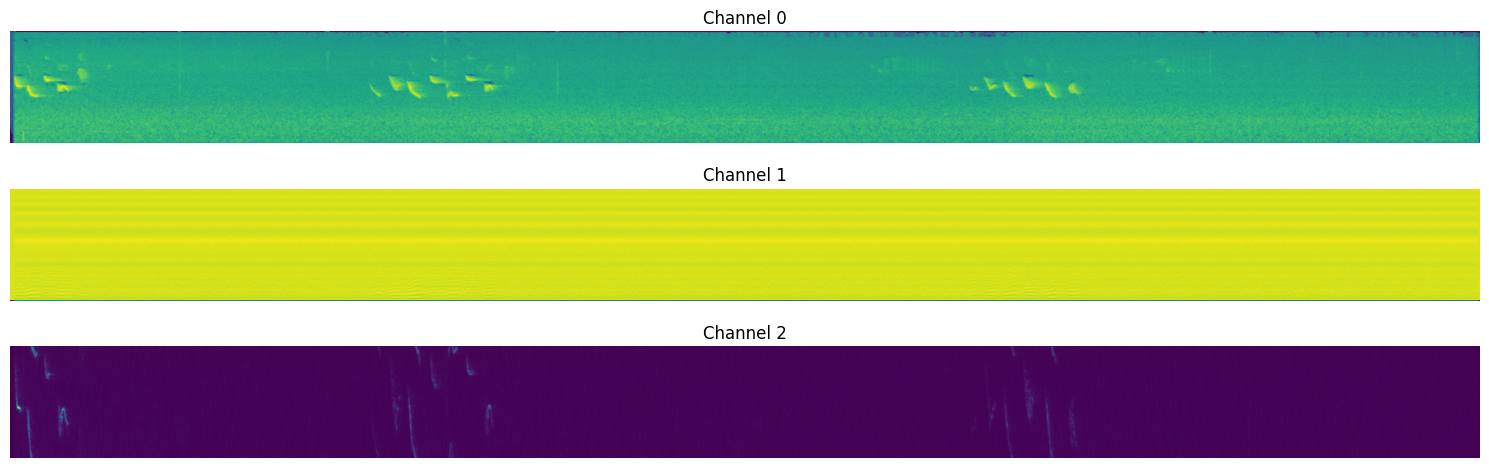

In [31]:
# plot each channel of threeChanels
fig, axs = plt.subplots(3, 1, figsize=(15, 5))
for i in range(3):
    axs[i].imshow(threeChanels[i].numpy(), cmap="viridis", origin="lower")
    axs[i].set_title(f"Channel {i}")
    axs[i].axis("off")
plt.tight_layout()
plt.show()